# PV Power Prediction — Quick Guide

Train a simple linear model to predict rooftop PV power from weather features; explore data, split train/test, evaluate metrics, and plot results.

#### Data source:
- Dryad dataset: Lin et al. (2024) — DOI: 10.5061/dryad.m37pvmd99 (https://datadryad.org/dataset/doi%3A10.5061/dryad.m37pvmd99)
- Article: Lin et al. (2025), Scientific Data 12, 63 — DOI: 10.1038/s41597-025-04397-y

#### How to use in Colab:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mrtn-gabriel/building-energy-prediction/blob/main/pv_ml_intro.ipynb)
1) Open this notebook in Colab by clicking the link above.
2) Runtime → Run all

#### Run locally:
- `python -m pip install -r requirements.txt`
- Open the notebook with JupyterLab or VS Code and run cells.


## Imports and Style
We import the libraries and set a simple plotting style.


In [ ]:
import sys

if 'google.colab' in sys.modules:
    !pip install -q "numpy>=1.23" "pandas>=1.5" "matplotlib>=3.6" "scikit-learn>=1.2" "seaborn>=0.12" "openpyxl>=3.1"
    !mkdir data
    !wget -P data/ "https://raw.githubusercontent.com/mrtn-gabriel/building-energy-prediction/refs/heads/main/data/SQ8.csv"

from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

sns.set_theme(context='talk', style='whitegrid')

## Load and Inspect Data


In [4]:
df = pd.read_csv('data/SQ8.csv', parse_dates=['time'], index_col='time')
df.head()

,power,irradiance,rh,slp,temp,vis,wind_speed,wind_direction
time,,,,,,,,
2021-04-12 07:00:00,286.0,17.0830,90.738,1007.94913,20.958,15.990,1.88180,3.6675
2021-04-12 08:00:00,1402.0,15.4290,88.580,1008.19913,21.795,15.989,0.60342,65.7850
2021-04-12 09:00:00,3182.0,17.3000,79.975,1008.09913,23.605,15.989,1.19120,16.1020
2021-04-12 10:00:00,5907.0,8.0436,81.307,1007.94913,23.553,15.993,0.98324,112.2000
2021-04-12 11:00:00,13743.0,5.3980,78.241,1007.77913,24.477,15.992,2.60770,122.9600


## Choose Features and Target
We predict `power` from weather features.


In [5]:
features = ['irradiance', 'rh', 'temp']
target = 'power'
df[features + [target]].head(3)


,irradiance,rh,temp,power
time,,,,
2021-04-12 07:00:00,17.083,90.738,20.958,286.0
2021-04-12 08:00:00,15.429,88.580,21.795,1402.0
2021-04-12 09:00:00,17.300,79.975,23.605,3182.0


## Train/Test Split by Year
Train on 2021–2022, test on 2023.


In [6]:
train_years = {2021, 2022}

train_mask = df.index.year.isin(train_years)
X_train, y_train = df.loc[train_mask, features], df.loc[train_mask, target]


test_mask = df.index.year == 2023
X_test, y_test = df.loc[test_mask, features], df.loc[test_mask, target]

print('Training set:')
X_train


Training set:


,irradiance,rh,temp
time,,,
2021-04-12 07:00:00,17.0830,90.738,20.958
2021-04-12 08:00:00,15.4290,88.580,21.795
2021-04-12 09:00:00,17.3000,79.975,23.605
2021-04-12 10:00:00,8.0436,81.307,23.553
2021-04-12 11:00:00,5.3980,78.241,24.477
...,...,...,...
2022-12-31 19:00:00,7.7296,61.192,15.337
2022-12-31 20:00:00,7.6190,64.047,14.475
2022-12-31 21:00:00,7.6195,65.872,14.095


# Scale Features
Features are standardized (zero mean, unit variance) with StandardScaler after train/test split.

In [7]:
# Scale features after splitting, before training
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pd.DataFrame(X_test).head()

,0,1,2
0,-0.555499,-0.829447,-1.664025
1,-0.557693,-0.636547,-1.785812
2,-0.558786,-0.488697,-1.907780
3,-0.557686,-0.470128,-1.966767
4,-0.553847,-0.455834,-1.999256


## Train a Linear Regression
We fit on the training years and predict the test year.


In [ ]:
from IPython.display import Markdown, display

model = LinearRegression()
model.fit(X_train, y_train)

coef = np.asarray(model.coef_, dtype=float).ravel()
intercept = float(model.intercept_)

terms = [f"{intercept:.2f}"] + [f"{c:+.2f}\\,{name}" for c, name in zip(coef, features)]
eq = "## Fitted linear function:\n" + rf"$$\widehat{{{target}}} = " + ' '.join(terms) + "$$"

display(Markdown(eq))


## Fitted linear function:
$$\widehat{power} = 3278.16 +4172.76\,irradiance -743.74\,rh +639.54\,temp$$

# Evaluate the trained model
Use $MAE$ and $R^2$ evaluation metric to evaluate model performance

MAE (W): 2102.4 | R^2: 0.58


<Axes: xlabel='time', ylabel='$P_{PV,electric} [W]$'>

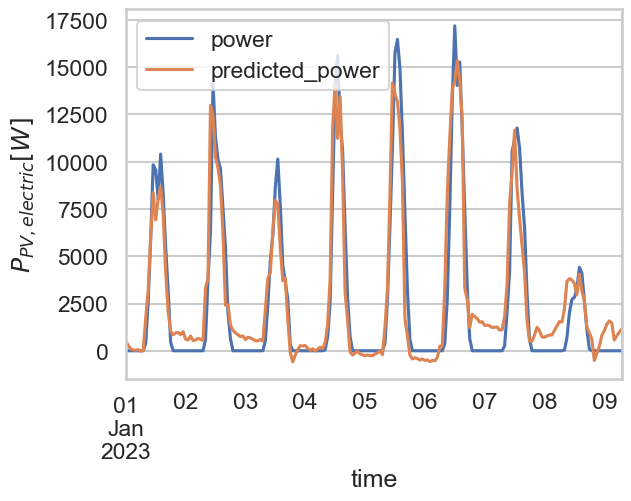

In [ ]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MAE (W):', round(mae,1), '| R^2:', round(r2,3))

df_pred = df.copy()
df_pred.loc[test_mask, 'predicted_power'] = y_pred
df_pred.loc[test_mask, ['power', 'predicted_power']].iloc[:200].plot(ylabel='$P_{PV,electric} [W]$')

## What Did the Model Learn?
Inspect linear coefficients. Larger magnitude = stronger influence.


In [19]:
coef = pd.Series(model.coef_, index=features).sort_values(ascending=False)
display(coef.to_frame('coef'))


,coef
irradiance,4172.758176
temp,639.536918
rh,-743.737345


## Next Steps
- Add more features (e.g., rainfall, pressure).
- Try different models (e.g., Ridge, Tree-based).
- Engineer features (add time, month, ...).
- Try another building dataset from the data folder
